# Import

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from joblib import Parallel, delayed
from tqdm import tqdm
from PIL import Image
import pdb
import lmdb
import pickle
import six
import pyarrow as pa
import msgpack

# Config

In [3]:
path_data = Path('data')

In [4]:
!ls {path_data}

cifar-10-batches-py  medium_size  small_size


# Load pickle

In [5]:
path_cifar = path_data/'cifar-10-batches-py'

In [6]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [7]:
data_batches = [unpickle(path_cifar/('data_batch_' + str(i))) for i in range(1,5)]

Get labels, data, and filenames. Note that files are png by default

In [8]:
labels = np.concatenate([data_batch[b'labels'] for data_batch in data_batches])
labels.shape

(40000,)

In [9]:
data = np.concatenate([data_batch[b'data'] for data_batch in data_batches])
data.shape

(40000, 3072)

In [10]:
filenames = np.concatenate([data_batch[b'filenames'] for data_batch in data_batches])
filenames.shape

(40000,)

# Utility functions

In [11]:
def format_img(img):
    return np.transpose(img.reshape(3, 32, 32), (1, 2, 0))

In [12]:
def imresize(img, sz):
    return np.array(Image.fromarray(img).resize(sz))

In [13]:
def save_image(idx, path_root, ext, sz=None):
    label = labels[idx]    
    img = format_img(data[idx])        
    filename = Path(filenames[idx].decode('UTF-8')).with_suffix('.' + ext)
    
    if sz is not None:
        img = imresize(img, sz)
    
    label_dir = path_root/str(label)
    label_dir.mkdir(parents=True, exist_ok=True)
    
    if ext == 'raw':
        img.astype('int8').tofile(label_dir/filename)
    else:
        Image.fromarray(img).save(label_dir/filename, compress_level=0)

# Save small size images

In [13]:
for ext in ['png', 'tif', 'jpg', 'raw']:
    root_path = path_data/'small_size'/ext
    Parallel(n_jobs=8)(delayed(save_image)(i, root_path, ext) for i in tqdm(range(len(filenames))));

100%|██████████| 40000/40000 [00:01<00:00, 27985.31it/s]


# Save medium size images

In [15]:
for ext in ['png', 'tif', 'jpg', 'raw']:
    root_path = path_data/'medium_size'/ext
    Parallel(n_jobs=8)(delayed(save_image)(i, root_path, ext, (256, 256)) for i in tqdm(range(len(filenames))));

100%|██████████| 40000/40000 [00:11<00:00, 3440.73it/s]


# Save large size images

In [14]:
for ext in ['png', 'tif', 'jpg', 'raw']:
    root_path = path_data/'large_size'/ext
    Parallel(n_jobs=8)(delayed(save_image)(i, root_path, ext, (512, 512)) for i in tqdm(range(len(filenames))));

100%|██████████| 40000/40000 [00:42<00:00, 938.81it/s] 


# Create LMDB store

In [42]:
def create_lmdb(path_dir, sz_img=None, sz_block=None):
    # Create database
    env = lmdb.open((path_data/path_dir/'lmdb').as_posix(), map_size=1.6e10)

    # Iterate in blocks, which is faster
    if sz_block is None:
        sz_block=len(data)
    
    # Get indices and then split into blocks
    idxs = np.arange(len(data))
    idx_blocks = np.split(idxs, np.ceil(len(data)/sz_block))    
    for idx_block in idx_blocks:
        with env.begin(write=True) as txn:
            for idx in idx_block:
                img = Image.fromarray(format_img(data[idx]))

                if sz_img is not None:
                    img = img.resize(sz_img)  

                # Indexed by filename
                txn.put(filenames[idx], pickle.dumps(img))
                
    # Close environemnt
    env.close()

In [43]:
create_lmdb('small_size')

In [52]:
# My machine runs out of ram if transactions arent chunked
create_lmdb('medium_size', (256, 256), 1000)

In [14]:
def read_batch(path_lmdb, keys):
    env = lmdb.open(path_lmdb.as_posix(), readonly=True)

    # Read all images as a single transaction
    with env.begin() as txn:
        imgs = [pickle.loads(txn.get(key.encode('ascii'))) for key in keys]
    
    # Close environment
    env.close()
    
    return imgs

In [56]:
imgs = read_batch(path_data/'medium_size'/'lmdb', ['dive_bomber_s_000004.png'])

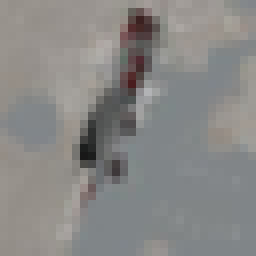

In [57]:
imgs[0]

In [64]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [65]:
def raw_reader(path):
    with open(path, 'rb') as f:
        bin_data = f.read()
    return bin_data

In [66]:
path_img = path_data/'medium_size'/'png'/'0'/'dive_bomber_s_000004.png'

In [67]:
img = Image.open(path_img)

In [68]:
db = lmdb.open(root_path.as_posix(), map_size=1e9)
with db.begin(write=True) as txn:
    txn.put(u'{}'.format(idx).encode('ascii'), pickle.dumps(img))

In [69]:
env = lmdb.open(root_path.as_posix(), readonly=True)
with env.begin(write=False) as txn:
    img = pickle.loads(txn.get(u'{}'.format(idx).encode('ascii')))

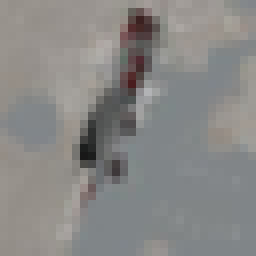

In [73]:
img

In [52]:
img_sz = 'medium_size'

root_path = path_data/img_sz/'lmdb'
root_path.mkdir(parents=True, exist_ok=True)

In [53]:
directory = path_data/img_sz/'jpg'
dataset = ImageFolder(directory, loader=raw_reader)
data_loader = DataLoader(dataset, num_workers=16, collate_fn=lambda x: x)

In [54]:
db = lmdb.open(root_path.as_posix(), map_size=1e9)

In [55]:
idx = 0
data = next(iter(data_loader))

In [56]:
image, label = data[0]
with db.begin(write=True) as txn:
    txn.put(u'{}'.format(idx).encode('ascii'),  pa.serialize((image, label)).to_buffer())

In [57]:
image

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x01\x00\x01\x00\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9\xca\xd2\xd3\

In [28]:
env = lmdb.open(root_path.as_posix(), readonly=True)
with env.begin(write=False) as txn:
    byteflow = txn.get(u'{}'.format(idx).encode('ascii'))

In [29]:
unpacked = pa.deserialize(byteflow)

In [30]:
buf = six.BytesIO()
buf.write(unpacked[0])
buf.seek(0)
img = Image.open(buf).convert('RGB')

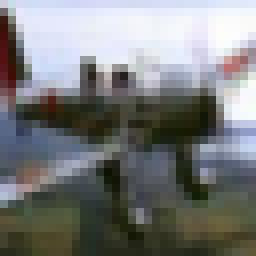

In [31]:
img

In [32]:
label

0

In [48]:
img.tobytes??

In [41]:
db = lmdb.open(root_path.as_posix(), map_size=1e9)
with db.begin(write=True) as txn:
    txn.put(u'{}'.format(idx).encode('ascii'), img.tobytes())

In [42]:
env = lmdb.open(root_path.as_posix(), readonly=True)
with env.begin(write=False) as txn:
    byteflow = txn.get(u'{}'.format(idx).encode('ascii'))

In [43]:
byteflow

b'\xc8\xce\xdc\xca\xcd\xdc\xcd\xcc\xdc\xce\xcb\xdc\xcf\xcb\xdc\xcf\xca\xde\xcd\xcc\xde\xc7\xce\xde\xcd\xdb\xe8\xc7\xdd\xea\xc4\xdf\xea\xc4\xdf\xea\xc6\xde\xea\xc7\xdd\xeb\xca\xdb\xeb\xcb\xdb\xeb\xd8\xd9\xf5\xd8\xd9\xf5\xd8\xd9\xf5\xd6\xda\xf5\xd6\xda\xf5\xd5\xdb\xf5\xd5\xdb\xf5\xd4\xdb\xf5\xd3\xda\xf4\xd1\xdb\xf4\xd0\xdc\xf4\xd0\xdc\xf4\xce\xdd\xf4\xce\xdd\xf4\xce\xdd\xf4\xce\xdd\xf4\xce\xde\xf7\xce\xde\xf7\xce\xde\xf7\xce\xde\xf7\xcf\xdd\xf7\xcf\xdd\xf7\xcf\xdd\xf7\xd1\xdd\xf7\xd1\xdd\xf7\xd1\xdd\xf7\xd1\xdd\xf7\xd2\xdc\xf7\xd2\xdc\xf7\xd2\xdc\xf7\xd2\xdc\xf7\xd2\xdc\xf7\xd1\xdd\xf7\xd1\xdd\xf7\xd1\xdd\xf7\xd1\xdd\xf7\xd1\xdd\xf7\xd1\xdd\xf7\xd1\xdd\xf7\xd1\xdd\xf7\xcf\xdb\xf5\xcf\xdb\xf5\xcf\xdb\xf5\xcf\xdb\xf5\xcf\xdb\xf5\xcf\xdb\xf5\xcf\xdb\xf5\xcf\xdb\xf5\xd1\xd7\xf9\xd1\xd7\xf9\xd1\xd7\xf9\xd1\xd7\xf9\xd1\xd7\xf9\xd1\xd7\xf9\xd1\xd7\xf9\xd1\xd7\xf9\xd0\xd6\xf8\xd0\xd6\xf8\xd0\xd6\xf8\xd0\xd6\xf8\xd0\xd6\xf8\xd0\xd6\xf8\xd0\xd6\xf8\xd0\xd6\xf8\xd4\xd7\xf8\xd4\xd7\xf8\xd4\xd7\xf8\x

In [46]:
from io import BytesIO

In [47]:
Image.open(BytesIO(byteflow)).convert('RGB')

OSError: cannot identify image file <_io.BytesIO object at 0x7f78f07d9308>

In [15]:
np.roll??